### QET Plots and Analysis of ||P||_\infty decay

use qsp_main6

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Generate Polynomial

In [2]:
def generate_random_polynomial(d, min_coeff=-30, max_coeff=30):
    coeffs = np.random.randint(min_coeff, max_coeff, size=d + 1)
    while coeffs[0] == 0:
        coeffs[0] = np.random.randint(min_coeff, max_coeff)
    poly = np.poly1d(coeffs)
    
    return poly


Generate Piecewise Chebyshevs

In [3]:
from numpy.polynomial.chebyshev import chebval

def generate_piecewise_chebyshev(domain, num_subintervals, degree, seed=None):
    """
    Generates a piecewise Chebyshev polynomial function ensuring continuity at knots.

    Parameters:
    - domain: tuple, the interval (a, b)
    - num_subintervals: int, number of subintervals
    - degree: int, degree of Chebyshev polynomials on each subinterval
    - seed: int or None, random seed for reproducibility

    Returns:
    - func: callable, the piecewise Chebyshev polynomial function
    - knots: numpy array, the partition points
    """
    if seed is not None:
        np.random.seed(seed)
    
    a, b = domain
    knots = np.linspace(a, b, num_subintervals + 1)
    polynomials = []
    
    # Initialize previous value for continuity
    prev_val = 0
    
    for i in range(num_subintervals):
        # Generate random coefficients for Chebyshev polynomial of given degree
        # Coefficients are in the Chebyshev basis
        coeffs = np.random.randn(degree + 1)
        
        # Create Chebyshev polynomial over [-1, 1]
        # To map to [knots[i], knots[i+1]], use linear transformation
        # x_mapped = (2x - (b + a)) / (b - a)
        # Here, a = knots[i], b = knots[i+1]
        def chebyshev_poly(x, coeffs=coeffs, a=knots[i], b=knots[i+1]):
            # Map x from [a, b] to [-1, 1]
            x_mapped = (2 * x - (b + a)) / (b - a)
            y = chebval(x_mapped, coeffs)
            return y
        
        # To ensure continuity, adjust the constant term so that P(a) = prev_val
        # P(a) = chebval(-1, coeffs) = sum_{k=0}^degree c_k T_k(-1)
        # Compute sum_{k=0}^degree c_k T_k(-1)
        T = np.cos(np.pi * np.arange(degree +1))  # T_k(-1) = (-1)^k
        poly_at_a = np.dot(coeffs, T)
        coeffs_adjusted = coeffs.copy()
        coeffs_adjusted[0] += prev_val - poly_at_a  # Adjust c0
        
        polynomials.append((coeffs_adjusted, knots[i], knots[i+1]))
        
        # Update prev_val to P(b)
        # P(b) = chebval(1, coeffs) = sum_{k=0}^degree c_k T_k(1) = c0 + c1 + ... + c_degree
        poly_at_b = np.dot(coeffs_adjusted, np.ones(degree +1))  # T_k(1) = 1
        prev_val = poly_at_b
    
    def func(x):
        """
        Evaluates the piecewise Chebyshev polynomial at x.

        Parameters:
        - x: float or numpy array

        Returns:
        - y: float or numpy array
        """
        x = np.array(x)
        y = np.zeros_like(x, dtype=np.float64)
        
        for coeffs, a, b in polynomials:
            mask = (x >= a) & (x <= b) if a != knots[-1] else (x >= a) & (x <= b + 1e-12)
            x_mapped = (2 * x[mask] - (b + a)) / (b - a)
            y[mask] = chebval(x_mapped, coeffs)
        
        return y
    
    return func

Fit Polynomial (Least Squares)

In [4]:
def generate_polynomial_fit(N, max_degree=None, x_range=(-1, 1), y_range=(-1, 1), seed=None):
    """
    Generates N random data points and fits a polynomial to them.
    The polynomial degree is the minimum of (N-1) and max_degree (if specified).
    
    Parameters:
        N (int): Number of data points.
        max_degree (int, optional): Maximum degree of the polynomial to fit. 
                                    If None, defaults to degree N-1 for exact fit.
        x_range (tuple): Range (min, max) for x values. Default is (-10, 10).
        y_range (tuple): Range (min, max) for y values. Default is (-10, 10).
        seed (int, optional): Seed for random number generator for reproducibility.
    
    Returns:
        poly_func (function): A function that takes x_vals and returns the polynomial evaluated at x_vals.
        x_vals (ndarray): The generated x data points.
        y_vals (ndarray): The generated y data points.
        polynomial (numpy.poly1d): The fitted polynomial object.
        degree_used (int): The degree of the fitted polynomial.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Step 1: Generate N distinct random x values within x_range
    x_vals = np.random.uniform(low=x_range[0], high=x_range[1], size=N)
    
    # Ensure all x values are unique
    while len(np.unique(x_vals)) < N:
        x_vals = np.random.uniform(low=x_range[0], high=x_range[1], size=N)
    
    # Step 2: Generate corresponding y values within y_range
    y_vals = np.random.uniform(low=y_range[0], high=y_range[1], size=N)
    
    # Step 3: Determine the degree of the polynomial
    if max_degree is None:
        degree = N - 1  # Exact fit
    else:
        degree = min(max_degree, N - 1)
    
    # Step 4: Fit the polynomial
    coefficients = np.polyfit(x_vals, y_vals, deg=degree)
    polynomial = np.poly1d(coefficients)
    
    # Step 5: Define the polynomial function
    def poly_func(x):
        return polynomial(x)
    
    return poly_func

In [5]:
def fit_polynomial(func, degree=3, num_points=1000):
    """
    Fits a polynomial of a given degree to a function over the domain [-1, 1].

    Parameters:
    - func: The function to fit.
    - degree: Degree of the polynomial to fit (default is 3).
    - num_points: Number of points to sample in the domain (default is 100).

    Returns:
    - p: A NumPy poly1d object representing the fitted polynomial.
    """
    # Generate equally spaced points in [-1, 1]
    x = np.linspace(-1, 1, num_points)
    y = func(x)

    # Fit the polynomial
    coefficients = np.polyfit(x, y, degree)

    # Create a polynomial function from the coefficients
    p = np.poly1d(coefficients)

    return p

GET DATA WITH REPEAT TRIALS

In [6]:
n_max = 25

In [7]:
decays = [] #will oscillate 5,10,20...,1000,5,10,20,...,1000,5,10... 50x repeats
scales = []

for j in range(50):   
    data_decay = []

    data_scaled = []

    for d in [5,10,20,50,100,250,1000]:
        f = generate_piecewise_chebyshev((-1,1),1,d)
        fmax_scaled_vals = []
        fmax_vals = []
        for n in range(n_max):
            x_vals = np.linspace(-1,1,2**n)
            f_vals = f(x_vals)
            normalised_f_vals = f_vals / np.linalg.norm(f_vals)
            fmax = np.max(np.abs(normalised_f_vals))
            fmax_scaled = fmax * np.sqrt(2**n)

            fmax_scaled_vals.append(fmax_scaled)
            fmax_vals.append(fmax)

        print(d)

        data_decay.append(fmax_vals)
        data_scaled.append(fmax_scaled_vals)

    decays.append(data_decay)
    scales.append(data_scaled)

5


C:\Users\0josh\AppData\Local\Temp\ipykernel_13992\501051970.py:16: RuntimeWarning: invalid value encountered in divide
  normalised_f_vals = f_vals / np.linalg.norm(f_vals)


10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250
1000
5
10
20
50
100
250

In [8]:
print(decays)
print(scales)

[[[1.0, 1.0, 0.9374314389735475, 0.5828712328394215, 0.4090691996332999, 0.2890089217800601, 0.20333673233532917, 0.1432082516077314, 0.10107552905726593, 0.0714028524783453, 0.05046495236452593, 0.03567539448135577, 0.0252232352711209, 0.017834433628573385, 0.012610464302085251, 0.008916808769856833, 0.006305087872391808, 0.004458353387523502, 0.003152525902378564, 0.0022291703182217544, 0.001576260697048041, 0.0011145843621444044, 0.0007881300667521697, 0.0005572920814499303, 0.0003940649981542097], [nan, 1.0, 0.8648569864841167, 0.6901834424120935, 0.5631102025829203, 0.42750963711338585, 0.30212677020478196, 0.2149891765498024, 0.15173710619646294, 0.10729580220350406, 0.0758413493774526, 0.053618174693495564, 0.03791036488313116, 0.02680551825408038, 0.018953944104932514, 0.013402313637893747, 0.009476814171105342, 0.006701100853658741, 0.0047383872537784645, 0.0033505434202968703, 0.002369191146592054, 0.0016752708333769041, 0.0011845952632761473, 0.0008376353070859508, 0.0005922

In [18]:
mean_decays = np.mean(decays, axis=0)  # Shape will be (7, 25)

mean_scaled = np.mean(scales,axis=0)

std_decays = np.std(decays,axis=0)

std_scaled = np.std(scales,axis=0)

print(mean_decays)
print(mean_scaled)

print(std_decays)
print(std_scaled)

[[           nan 1.00000000e+00 8.10754203e-01 6.41850877e-01
  4.67685186e-01 3.35795836e-01 2.38992409e-01 1.69381375e-01
  1.19886884e-01 8.48097129e-02 5.99819641e-02 4.24179722e-02
  2.99955292e-02 2.12105669e-02 1.49983205e-02 1.06054793e-02
  7.49922939e-03 5.30276409e-03 3.74962333e-03 2.65138510e-03
  1.87481274e-03 1.32569293e-03 9.37406506e-04 6.62846513e-04
  4.68703270e-04]
 [           nan 1.00000000e+00 8.26542247e-01 6.14189721e-01
  4.67136646e-01 3.44340233e-01 2.47249904e-01 1.75337055e-01
  1.24049880e-01 8.77356682e-02 6.20399874e-02 4.38689659e-02
  3.10198644e-02 2.19342707e-02 1.55098359e-02 1.09670969e-02
  7.75490379e-03 5.48354335e-03 3.87745008e-03 2.74177103e-03
  1.93872481e-03 1.37088543e-03 9.69362375e-04 6.85442706e-04
  4.84681184e-04]
 [           nan 1.00000000e+00 8.27758436e-01 6.47843996e-01
  5.05263915e-01 3.72305086e-01 2.67953154e-01 1.92724310e-01
  1.36704563e-01 9.68694657e-02 6.85273733e-02 4.84662148e-02
  3.42717760e-02 2.42340606e-02 1.

In [ ]:
plt.plot(np.linspace(-1,1,2**1000))

In [11]:
inverse_sqrt_n = [1/np.sqrt(2**n) for n in range(25)]

Visualisation

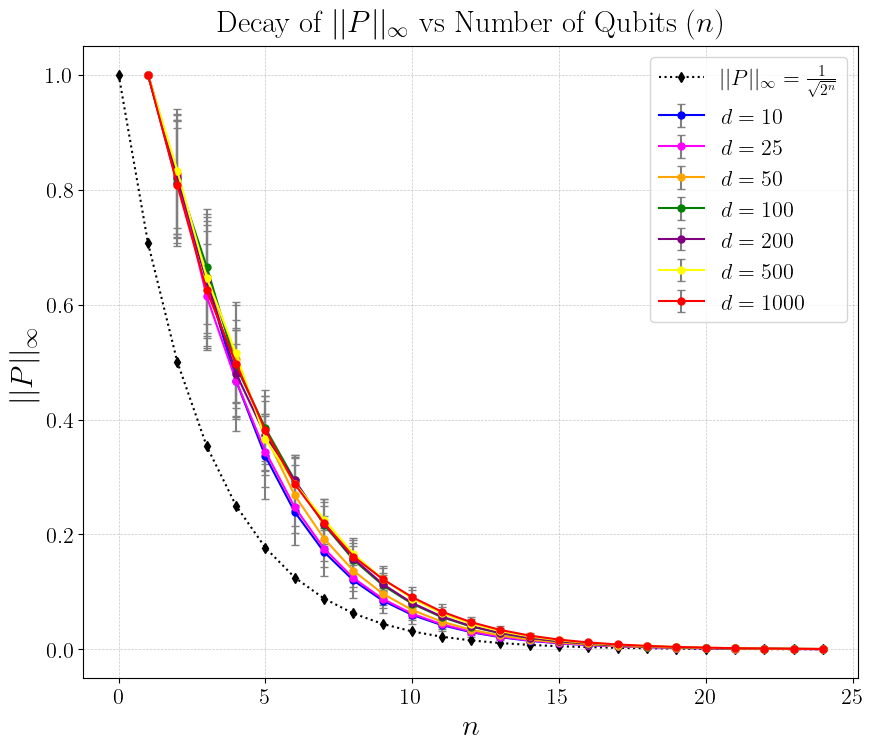

In [19]:
import matplotlib.pyplot as plt
import matplotlib

# Use LaTeX fonts
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

# Set font sizes
plt.rc('axes', titlesize=22)     # Title font size
plt.rc('axes', labelsize=22)     # Axis labels font size
plt.rc('xtick', labelsize=16)    # X tick labels font size
plt.rc('ytick', labelsize=16)    # Y tick labels font size
plt.rc('legend', fontsize=16)    # Legend font size

# Labels and colors
colors = ['blue','magenta','orange','green','purple','yellow','red']
labels = [10, 25, 50, 100, 200, 500, 1000]

# Create the figure
plt.figure(figsize=(10, 8))

# Plot each dataset with error bars
for j, d in enumerate(labels):
    x_values = range(n_max)  # Assuming n starts from 0; adjust if n starts from 1
    plt.errorbar(
        x_values,
        mean_decays[j],
        yerr=std_decays[j],
        fmt='o-',                          # Marker 'o' with solid line '-'
        color=colors[j],
        ecolor='gray',                     # Color of the error bars
        capsize=3,                         # Size of the error bar caps
        label=rf'$d = {d}$',
        markersize=5,                      # Size of the markers
        linewidth=1.5                      # Width of the lines
    )

# Plot the inverse_sqrt_n line
plt.plot(
    range(n_max),
    inverse_sqrt_n,
    marker='d',
    linestyle=':',
    color='black',
    label=r'$||P||_\infty = \frac{1}{\sqrt{2^n}}$',
    markersize=5,
    linewidth=1.5
)

# Set title and labels with LaTeX formatting and increased padding
plt.title(r'Decay of $||P||_\infty$ vs Number of Qubits $(n)$', pad=10)
plt.xlabel(r'$n$')
plt.ylabel(r'$||P||_\infty$')

# Adjust the top margin to give the title more room
plt.subplots_adjust(top=0.9)

# Add grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()

# Save the figure with high resolution
plt.savefig(
    r'C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\QET Plots\decay_P_max2.png',
    dpi=600,
    bbox_inches='tight',
    transparent=False
)

# Display the plot
plt.show()


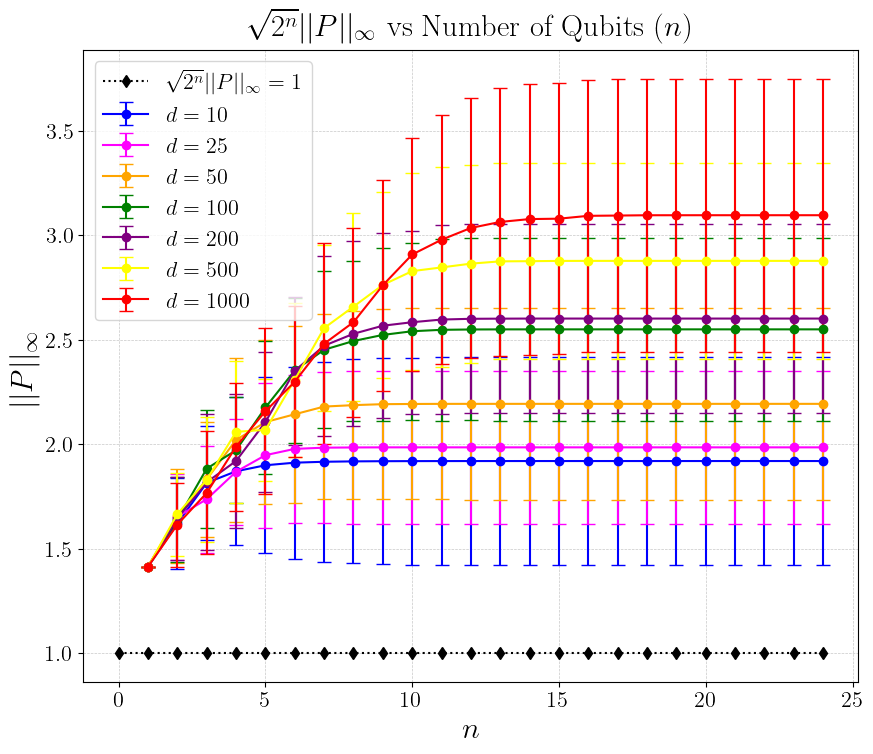

In [20]:
import matplotlib.pyplot as plt
import matplotlib

# Use LaTeX fonts
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

# Set font sizes
plt.rc('axes', titlesize=22)     # Title font size
plt.rc('axes', labelsize=22)     # Axis labels font size
plt.rc('xtick', labelsize=16)    # X tick labels font size
plt.rc('ytick', labelsize=16)    # Y tick labels font size
plt.rc('legend', fontsize=16)    # Legend font size

# Create the figure
plt.figure(figsize=(10, 8))

# Define your colors and labels
colors = ['blue', 'magenta', 'orange', 'green', 'purple', 'yellow', 'red']
labels = [10, 25, 50, 100, 200, 500, 1000]  # Corresponding d values

# Ensure that mean_scaled and std_scaled are defined and have the correct dimensions
# mean_scaled: List of lists where each sublist corresponds to a specific d value across n_max
# std_scaled: List of lists with the same structure as mean_scaled containing standard deviations

j = 0
for d in range(len(labels)):
    # Replace plt.plot with plt.errorbar to include error bars
    plt.errorbar(
        range(n_max),                # X-axis values (number of qubits)
        mean_scaled[j],              # Y-axis mean values for current d
        yerr=std_scaled[j],          # Y-axis error bars (standard deviations)
        marker='o',                  # Marker style
        linestyle='-',               # Line style
        color=colors[j],             # Line and marker color
        label=rf'$d = {labels[j]}$',  # Legend label with actual d value
        capsize=5,                    # Size of the error bar caps
        markersize=6,                 # Size of the markers
        linewidth=1.5                 # Thickness of the lines
    )
    j += 1

# Plot the reference line without error bars
plt.plot(
    range(n_max),
    [1]*n_max,
    marker='d',
    linestyle=':',
    color='black',
    label=r'$\sqrt{2^n}||P||_\infty = 1$',
    markersize=6,
    linewidth=1.5
)

# Set title and labels with LaTeX formatting and increased padding
plt.title(r'$\sqrt{2^n}||P||_\infty$ vs Number of Qubits $(n)$', pad=10)
plt.xlabel(r'$n$')
plt.ylabel(r'$||P||_\infty$')

# Adjust the top margin to give the title more room
plt.subplots_adjust(top=0.9)

# Add grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Enhanced grid for better readability
plt.legend()

# Save the figure with high resolution
plt.savefig(
    r'C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\QET Plots\scaled_P_max.png',
    dpi=600,
    bbox_inches='tight',
    transparent=False
)

# Display the plot
plt.show()


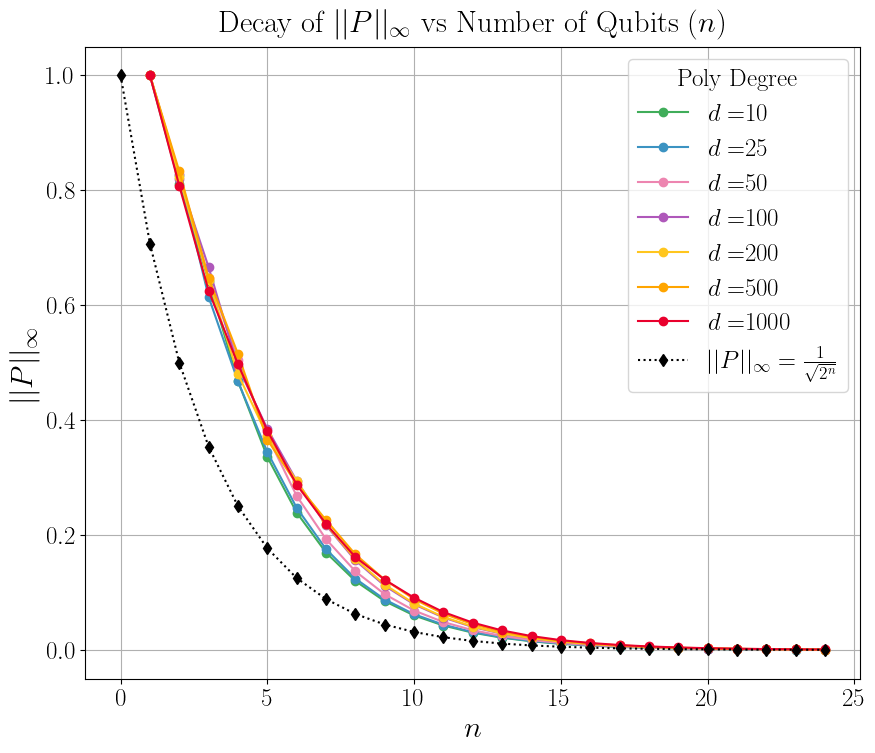

In [39]:
import matplotlib.pyplot as plt
import matplotlib

# Use LaTeX fonts
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

# Set font sizes
plt.rc('axes', titlesize=22)     # Title font size
plt.rc('axes', labelsize=22)     # Axis labels font size
plt.rc('xtick', labelsize=18)    # X tick labels font size
plt.rc('ytick', labelsize=18)    # Y tick labels font size
plt.rc('legend', fontsize=18)    # Legend font size

# Create the figure
plt.figure(figsize=(10, 8))

# Plot the data with improved styles

colors = ["#40AD5A","#3C93C2","#ED85B0","#AF58BA","#FFC61E",'orange',"#E9002D"]


labels = [10,25,50,100,200,500,1000]

j = 0
for d in range(len([10,25,50,100,200,500,1000])):
    plt.plot(range(n_max), mean_decays[j], marker='o', linestyle='-', color=colors[j], label=rf'$d = ${labels[d]}')
    j+=1

plt.plot(range(n_max), inverse_sqrt_n, marker='d', linestyle=':', color='black', label=r'$||P||_\infty = \frac{1}{\sqrt{2^n}}$')

# Set title and labels with LaTeX formatting and increased padding
plt.title(r'Decay of $||P||_\infty$ vs Number of Qubits $(n)$', pad=10)
plt.xlabel(r'$n$')
plt.ylabel(r'$||P||_\infty$')

# Adjust the top margin to give the title more room
plt.subplots_adjust(top=0.9)

# Add grid and legend
plt.grid(True)
plt.legend(title=r"Poly Degree",title_fontsize=18)

# Save the figure with high resolution
plt.savefig(r'C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\QET Plots\decay_P_max.png',
            dpi=600, bbox_inches='tight', transparent=False)

# Display the plot
plt.show()


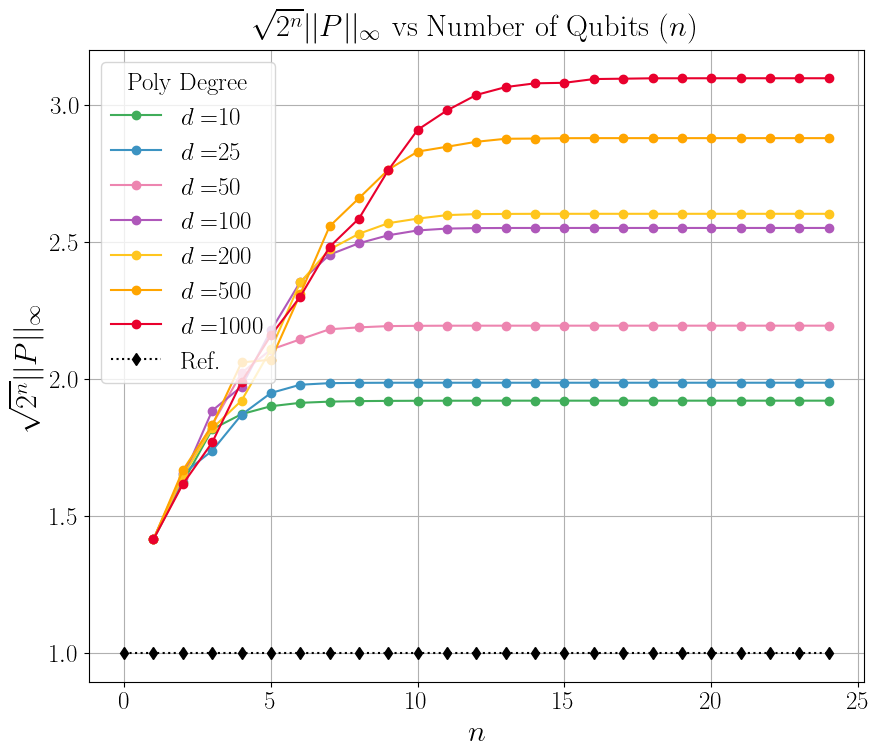

In [40]:
import matplotlib.pyplot as plt
import matplotlib

# Use LaTeX fonts
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

plt.rc('axes', titlesize=22)     # Title font size
plt.rc('axes', labelsize=22)     # Axis labels font size
plt.rc('xtick', labelsize=18)    # X tick labels font size
plt.rc('ytick', labelsize=18)    # Y tick labels font size
plt.rc('legend', fontsize=18)    # Legend font size

# Create the figure
plt.figure(figsize=(10, 8))

# Plot the data with improved styles

colors = ["#40AD5A","#3C93C2","#ED85B0","#AF58BA","#FFC61E",'orange',"#E9002D"]

j = 0
for d in range(len([10,25,50,100,200,500,1000])):
    plt.plot(range(n_max), mean_scaled[j], marker='o', linestyle='-', color=colors[j], label=rf'$d = ${labels[d]}')
    j+=1

plt.plot(range(n_max), [1]*n_max, marker='d', linestyle=':', color='black', label=r'Ref.')

# Set title and labels with LaTeX formatting and increased padding
plt.title(r'$\sqrt{2^n}||P||_\infty$ vs Number of Qubits $(n)$', pad=10)
plt.xlabel(r'$n$')
plt.ylabel(r'$\sqrt{2^n}||P||_\infty$')

# Adjust the top margin to give the title more room
plt.subplots_adjust(top=0.9)

# Add grid and legend
plt.grid(True)
plt.legend(title=r"Poly Degree",title_fontsize=18,loc='upper left')

# Save the figure with high resolution
plt.savefig(r'C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\QET Plots\scaled_P_max.png',
            dpi=600, bbox_inches='tight', transparent=False)

# Display the plot
plt.show()


#### Other Data (incl. in Appendices)

In [151]:
n_max = 25

In [344]:
p10 = generate_polynomial_fit(1500,max_degree=10)
p10_infties = []
p10_scaled_infties = []

for n in range(n_max):
    x_vals = np.linspace(-1,1,2**n)
    p10_vals = p10(x_vals)
    norm_p10_vals = p10_vals/np.linalg.norm(p10_vals)
    p10_infty = max(abs(norm_p10_vals))
    p10_infties.append(p10_infty)
    p10_scaled_infties.append(p10_infty * np.sqrt(2**n))

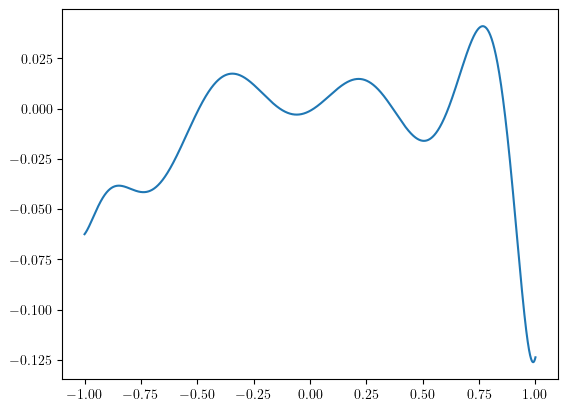

In [345]:
plt.plot(x_vals, p10_vals); plt.show()

In [346]:
p30 = generate_polynomial_fit(1500,max_degree=30)
p30_infties = []
p30_scaled_infties = []

for n in range(n_max):
    x_vals = np.linspace(-1,1,2**n)
    p30_vals = p30(x_vals)
    norm_p30_vals = p30_vals/np.linalg.norm(p30_vals)
    p30_infty = max(abs(norm_p30_vals))
    p30_infties.append(p30_infty)
    p30_scaled_infties.append(p30_infty * np.sqrt(2**n))

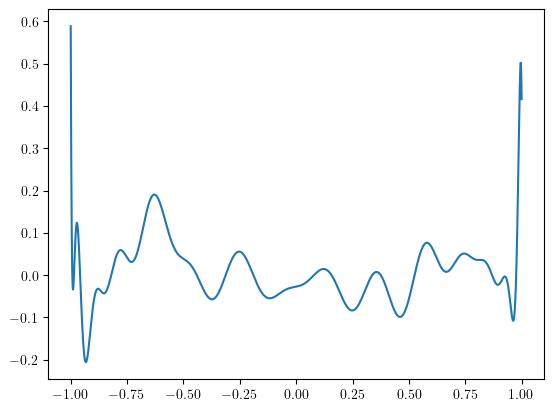

In [347]:
plt.plot(x_vals, p30_vals); plt.show()

In [356]:
p100 = generate_polynomial_fit(1500,max_degree=100)
p100_infties = []
p100_scaled_infties = []

for n in range(n_max):
    x_vals = np.linspace(-1,1,2**n)
    p100_vals = p100(x_vals)
    norm_p100_vals = p100_vals/np.linalg.norm(p100_vals)
    p100_infty = max(abs(norm_p100_vals))
    p100_infties.append(p100_infty)
    p100_scaled_infties.append(p100_infty * np.sqrt(2**n))

C:\Users\0josh\AppData\Local\Temp\ipykernel_5264\2342417050.py:41: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_vals, y_vals, deg=degree)


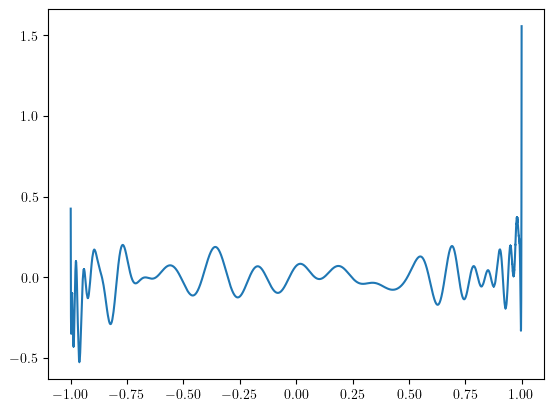

In [357]:
plt.plot(x_vals, p100_vals); plt.show()

In [271]:
p200 = generate_polynomial_fit(1000,max_degree=200)
p200_infties = []
p200_scaled_infties = []

for n in range(n_max):
    x_vals = np.linspace(-1,1,2**n)
    p200_vals = p200(x_vals)
    norm_p200_vals = p200_vals/np.linalg.norm(p200_vals)
    p200_infty = max(abs(norm_p200_vals))
    p200_infties.append(p200_infty)
    p200_scaled_infties.append(p200_infty * np.sqrt(2**n))

C:\Users\0josh\AppData\Local\Temp\ipykernel_5264\2342417050.py:41: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_vals, y_vals, deg=degree)


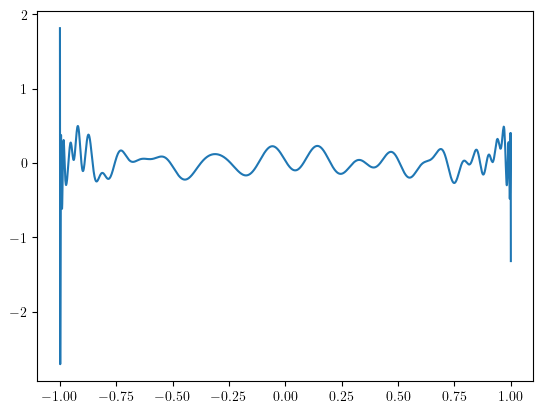

In [272]:
plt.plot(x_vals, p200_vals); plt.show()

In [311]:
f1_def= lambda x: np.cos(2*np.pi*x)
f1_infties = []
f1_scaled_infties = []

for n in range(n_max):
    f1 = fit_polynomial(f1_def, 15, 2**n)
    x_vals = np.linspace(-1,1,2**n)
    f1_vals = f1(x_vals)
    norm_f1_vals = f1_vals/np.linalg.norm(f1_vals)
    f1_infty = max(abs(norm_f1_vals))
    f1_infties.append(f1_infty)
    f1_scaled_infties.append(f1_infty * np.sqrt(2**n))

C:\Users\0josh\AppData\Local\Temp\ipykernel_5264\4079728419.py:18: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
C:\Users\0josh\AppData\Local\Temp\ipykernel_5264\4079728419.py:18: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
C:\Users\0josh\AppData\Local\Temp\ipykernel_5264\4079728419.py:18: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
C:\Users\0josh\AppData\Local\Temp\ipykernel_5264\4079728419.py:18: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)


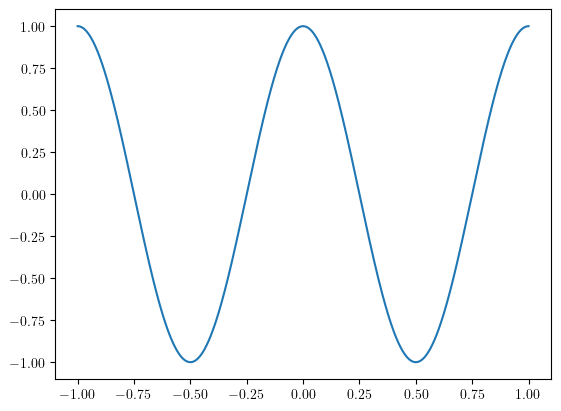

In [312]:
plt.plot(x_vals, f1_vals); plt.show()

In [309]:
f2_def = lambda x: np.sqrt(x+1)
f2_infties = []
f2_scaled_infties = []


for n in range(n_max):
    f2 = fit_polynomial(f2_def, 20, 2**n)
    x_vals = np.linspace(-1,1,2**n)
    f2_vals = f2(x_vals)
    norm_f2_vals = f2_vals/np.linalg.norm(f2_vals)
    f2_infty = max(abs(norm_f2_vals))
    f2_infties.append(f2_infty)
    f2_scaled_infties.append(f2_infty * np.sqrt(2**n))

C:\Users\0josh\AppData\Local\Temp\ipykernel_5264\4079728419.py:18: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
C:\Users\0josh\AppData\Local\Temp\ipykernel_5264\447477872.py:10: RuntimeWarning: invalid value encountered in divide
  norm_f2_vals = f2_vals/np.linalg.norm(f2_vals)
C:\Users\0josh\AppData\Local\Temp\ipykernel_5264\4079728419.py:18: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
C:\Users\0josh\AppData\Local\Temp\ipykernel_5264\4079728419.py:18: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
C:\Users\0josh\AppData\Local\Temp\ipykernel_5264\4079728419.py:18: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)
C:\Users\0josh\AppData\Local\Temp\ipykernel_5264\4079728419.py:18: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x, y, degree)


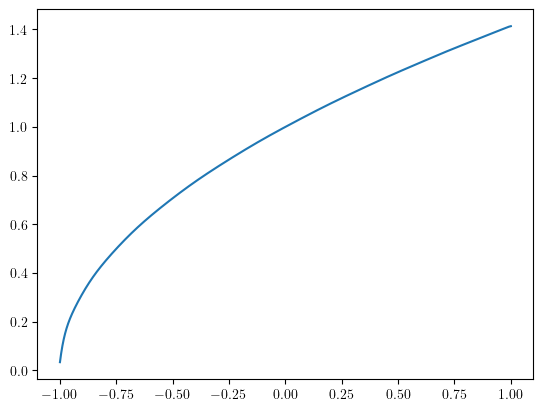

In [310]:
plt.plot(x_vals, f2_vals); plt.show()

In [195]:
inverse_sqrt_n = [1/np.sqrt(2**n) for n in range(25)]

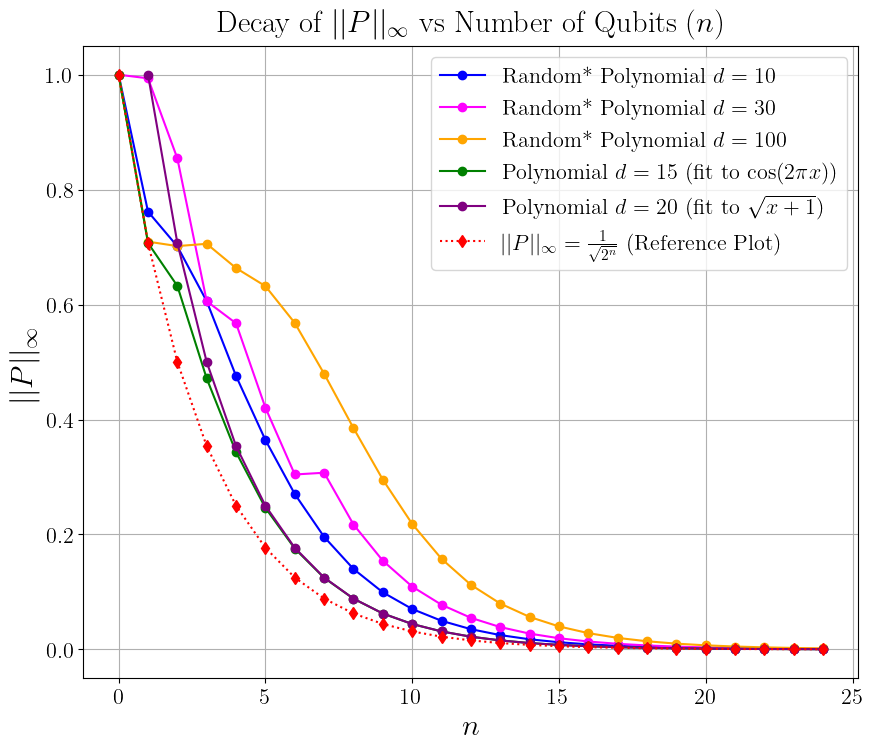

In [213]:
import matplotlib.pyplot as plt
import matplotlib

# Use LaTeX fonts
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

# Set font sizes
plt.rc('axes', titlesize=22)     # Title font size
plt.rc('axes', labelsize=22)     # Axis labels font size
plt.rc('xtick', labelsize=16)    # X tick labels font size
plt.rc('ytick', labelsize=16)    # Y tick labels font size
plt.rc('legend', fontsize=16)    # Legend font size

# Create the figure
plt.figure(figsize=(10, 8))

# Plot the data with improved styles
plt.plot(range(n_max), p10_infties, marker='o', linestyle='-', color='blue', label=r'Random* Polynomial $d = 10$')
plt.plot(range(n_max), p30_infties, marker='o', linestyle='-', color='magenta', label=r'Random* Polynomial $d = 30$')
plt.plot(range(n_max), p100_infties, marker='o', linestyle='-', color='orange', label=r'Random* Polynomial $d = 100$')
plt.plot(range(n_max), f1_infties, marker='o', linestyle='-', color='green', label=r'Polynomial $d = 15$ (fit to $\cos({2\pi x})$)')
plt.plot(range(n_max), f2_infties, marker='o', linestyle='-', color='purple', label=r'Polynomial $d = 20$ (fit to $\sqrt{x+1}$)')
plt.plot(range(n_max), inverse_sqrt_n, marker='d', linestyle=':', color='red', label=r'$||P||_\infty = \frac{1}{\sqrt{2^n}}$ (Reference Plot)')

# Set title and labels with LaTeX formatting and increased padding
plt.title(r'Decay of $||P||_\infty$ vs Number of Qubits $(n)$', pad=10)
plt.xlabel(r'$n$')
plt.ylabel(r'$||P||_\infty$')

# Adjust the top margin to give the title more room
plt.subplots_adjust(top=0.9)

# Add grid and legend
plt.grid(True)
plt.legend()

# Save the figure with high resolution
plt.savefig(r'C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\QET Plots\Decay of max_P1.png',
            dpi=300, bbox_inches='tight', transparent=True)

# Display the plot
plt.show()


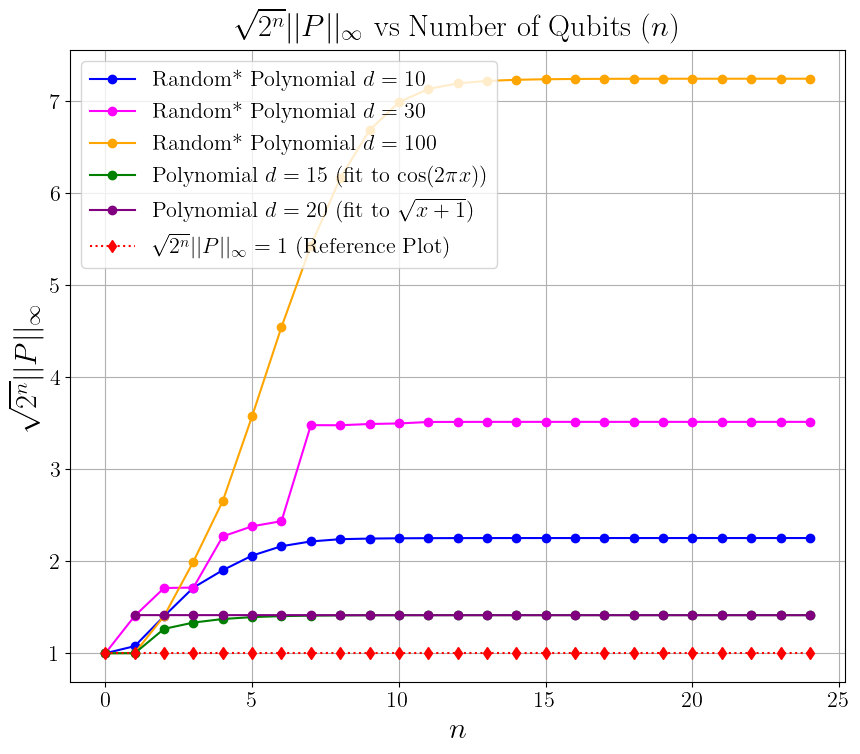

In [219]:
import matplotlib.pyplot as plt
import matplotlib

# Use LaTeX fonts
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

# Set font sizes
plt.rc('axes', titlesize=22)     # Title font size
plt.rc('axes', labelsize=22)     # Axis labels font size
plt.rc('xtick', labelsize=16)    # X tick labels font size
plt.rc('ytick', labelsize=16)    # Y tick labels font size
plt.rc('legend', fontsize=16)    # Legend font size

# Create the figure
plt.figure(figsize=(10, 8))

# Plot the data with improved styles
plt.plot(range(n_max), p10_scaled_infties, marker='o', linestyle='-', color='blue', label=r'Random* Polynomial $d = 10$')
plt.plot(range(n_max), p30_scaled_infties, marker='o', linestyle='-', color='magenta', label=r'Random* Polynomial $d = 30$')
plt.plot(range(n_max), p100_scaled_infties, marker='o', linestyle='-', color='orange', label=r'Random* Polynomial $d = 100$')
plt.plot(range(n_max), f1_scaled_infties, marker='o', linestyle='-', color='green', label=r'Polynomial $d = 15$ (fit to $\cos({2\pi x})$)')
plt.plot(range(n_max), f2_scaled_infties, marker='o', linestyle='-', color='purple', label=r'Polynomial $d = 20$ (fit to $\sqrt{x+1}$)')
plt.plot(range(n_max), [1]*n_max, marker='d', linestyle=':', color='red', label=r'$\sqrt{2^n}||P||_\infty = 1$ (Reference Plot)')

# Set title and labels with LaTeX formatting and increased padding
plt.title(r'$\sqrt{2^n}||P||_\infty$ vs Number of Qubits $(n)$', pad=10)
plt.xlabel(r'$n$')
plt.ylabel(r'$\sqrt{2^n}||P||_\infty$')

# Adjust the top margin to give the title more room
plt.subplots_adjust(top=0.9)

# Add grid and legend
plt.grid(True)
plt.legend()

# Save the figure with high resolution
plt.savefig(r'C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\QET Plots\Decay of max_P.png',
            dpi=300, bbox_inches='tight', transparent=True)

# Display the plot
plt.show()


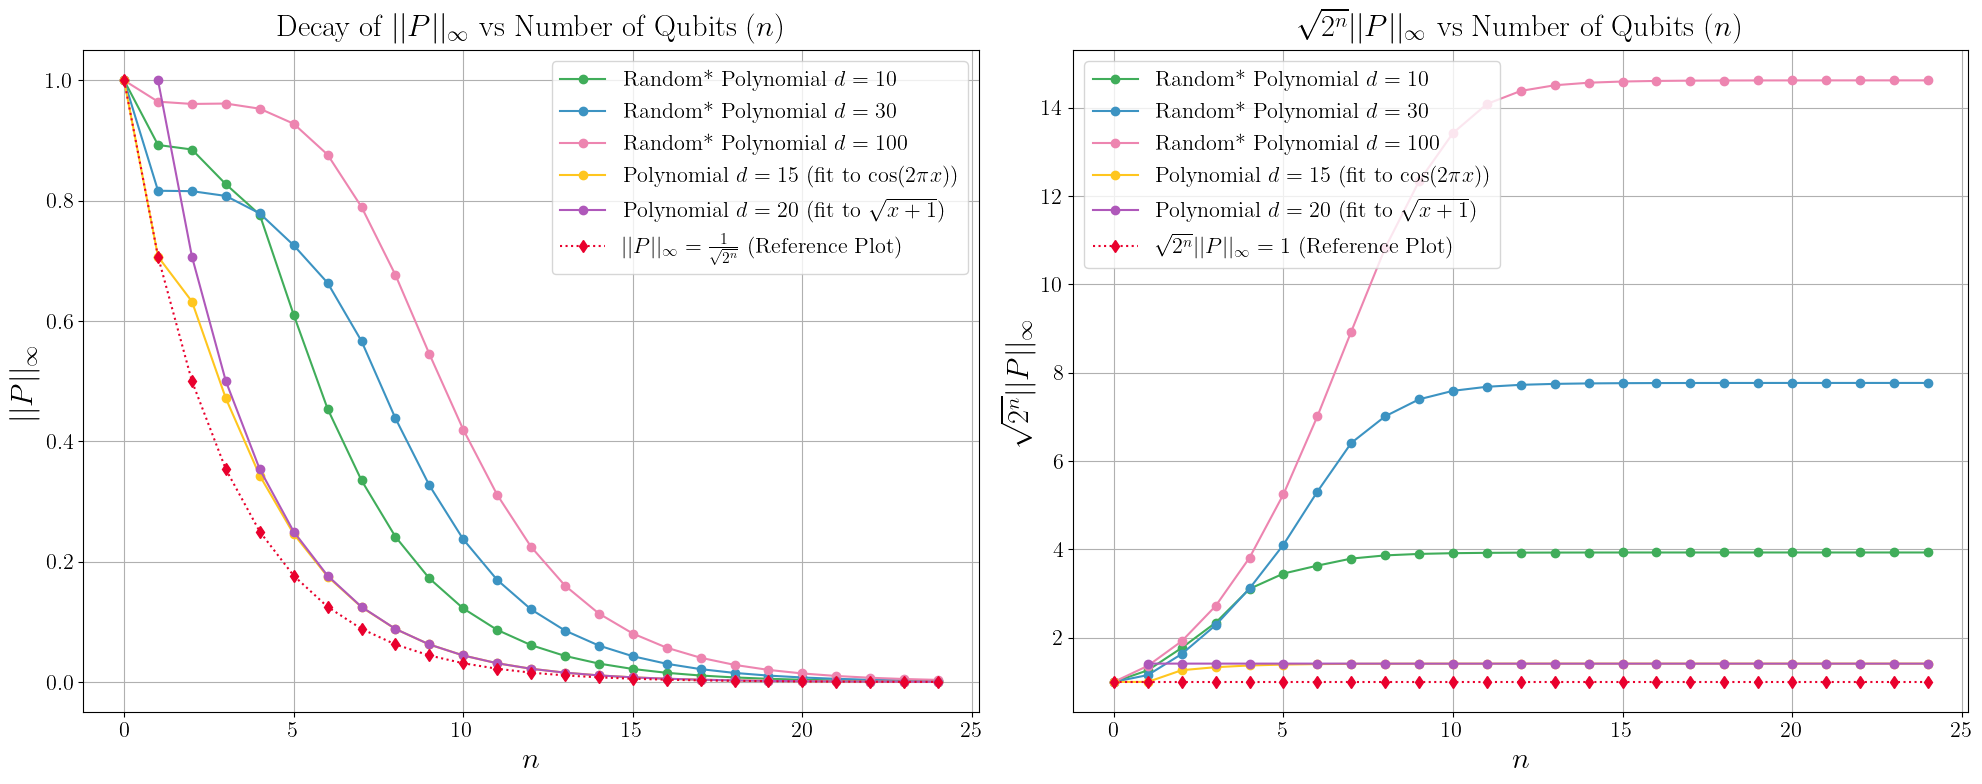

In [361]:
import matplotlib.pyplot as plt
import matplotlib

# Use LaTeX fonts
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

# Set font sizes
plt.rc('axes', titlesize=22)     # Title font size
plt.rc('axes', labelsize=22)     # Axis labels font size
plt.rc('xtick', labelsize=16)    # X tick labels font size
plt.rc('ytick', labelsize=16)    # Y tick labels font size
plt.rc('legend', fontsize=16)    # Legend font size

# Create the figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# ===========================
# First Plot: Decay of ||P||_infty vs n
# ===========================
ax1 = axes[0]  # First subplot

colours = ["#40AD5A","#3C93C2","#ED85B0","#FFC61E","#AF58BA","#E9002D"]
# Plot the data with improved styles
ax1.plot(range(n_max), p10_infties, marker='o', linestyle='-', color=colours[0], label=r'Random* Polynomial $d = 10$')
ax1.plot(range(n_max), p30_infties, marker='o', linestyle='-', color=colours[1], label=r'Random* Polynomial $d = 30$')
ax1.plot(range(n_max), p100_infties, marker='o', linestyle='-', color=colours[2], label=r'Random* Polynomial $d = 100$')
ax1.plot(range(n_max), f1_infties, marker='o', linestyle='-', color=colours[3], label=r'Polynomial $d = 15$ (fit to $\cos({2\pi x})$)')
ax1.plot(range(n_max), f2_infties, marker='o', linestyle='-', color=colours[4], label=r'Polynomial $d = 20$ (fit to $\sqrt{x+1}$)')
ax1.plot(range(n_max), inverse_sqrt_n, marker='d', linestyle=':', color=colours[5], label=r'$||P||_\infty = \frac{1}{\sqrt{2^n}}$ (Reference Plot)')

# Set title and labels with LaTeX formatting and increased padding
ax1.set_title(r'Decay of $||P||_\infty$ vs Number of Qubits $(n)$', pad=10)
ax1.set_xlabel(r'$n$')
ax1.set_ylabel(r'$||P||_\infty$')

# Add grid and legend
ax1.grid(True)
ax1.legend()

# ===========================
# Second Plot: Scaled Decay of ||P||_infty vs n
# ===========================
ax2 = axes[1]  # Second subplot

# Plot the scaled data with improved styles
ax2.plot(range(n_max), p10_scaled_infties, marker='o', linestyle='-', color=colours[0], label=r'Random* Polynomial $d = 10$')
ax2.plot(range(n_max), p30_scaled_infties, marker='o', linestyle='-', color=colours[1], label=r'Random* Polynomial $d = 30$')
ax2.plot(range(n_max), p100_scaled_infties, marker='o', linestyle='-', color=colours[2], label=r'Random* Polynomial $d = 100$')
ax2.plot(range(n_max), f1_scaled_infties, marker='o', linestyle='-', color=colours[3], label=r'Polynomial $d = 15$ (fit to $\cos({2\pi x})$)')
ax2.plot(range(n_max), f2_scaled_infties, marker='o', linestyle='-', color=colours[4], label=r'Polynomial $d = 20$ (fit to $\sqrt{x+1}$)')
ax2.plot(range(n_max), [1]*n_max, marker='d', linestyle=':', color=colours[5], label=r'$\sqrt{2^n}||P||_\infty = 1$ (Reference Plot)')

# Set title and labels with LaTeX formatting and increased padding
ax2.set_title(r'$\sqrt{2^n}||P||_\infty$ vs Number of Qubits $(n)$', pad=10)
ax2.set_xlabel(r'$n$')
ax2.set_ylabel(r'$\sqrt{2^n}||P||_\infty$')

# Add grid and legend
ax2.grid(True)
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the combined figure with high resolution
plt.savefig(
    r'C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\QET Plots\Decay_of_max_P_side_by_side_final.png',
    dpi=300, bbox_inches='tight', transparent=True
)

# Display the plot
plt.show()


C:\Users\0josh\AppData\Local\Temp\ipykernel_5264\4126454549.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(
c:\Users\0josh\miniconda3\envs\qsp_main6\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


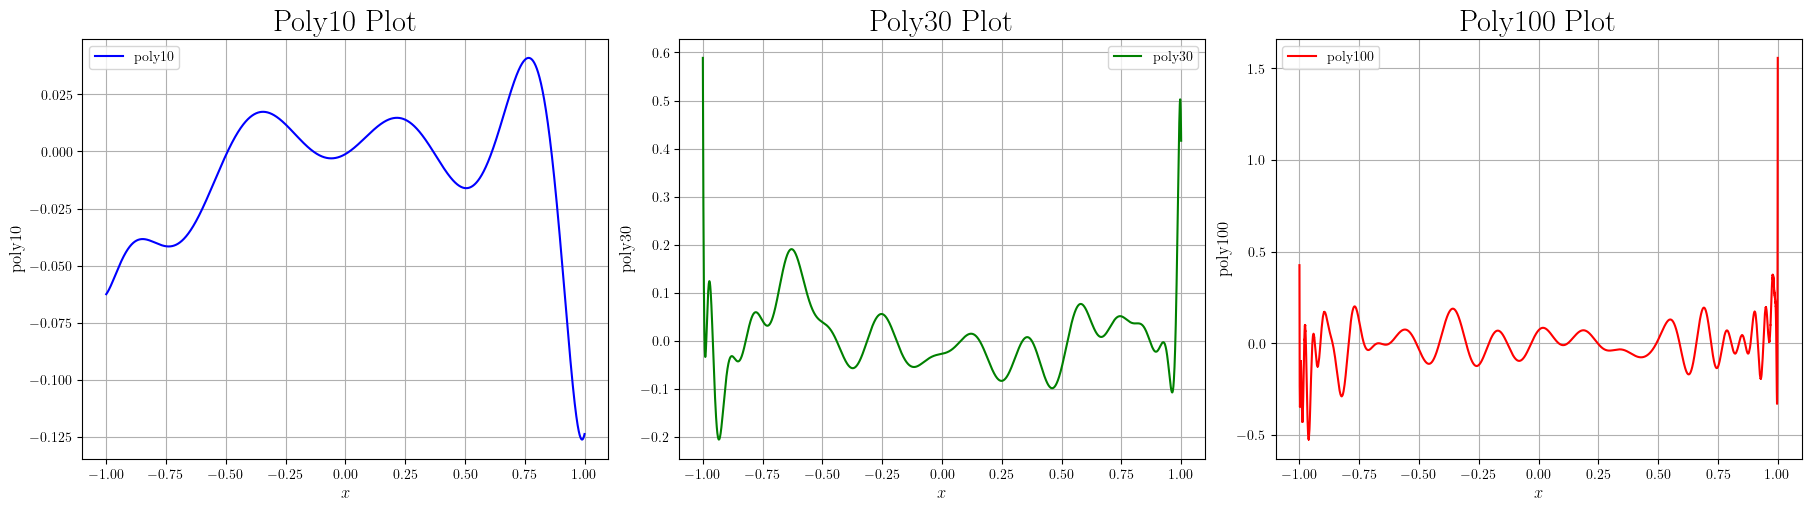

In [362]:
import matplotlib.pyplot as plt
import numpy as np

# Sample Data (Replace these with your actual data)
# Enable LaTeX-style fonts in matplotlib
plt.rcParams.update({
    "text.usetex": True,            # Use LaTeX for text rendering
    "font.family": "serif",         # Use a serif font
    "font.serif": ["Computer Modern"],  # Specify the serif font
    "axes.labelsize": 12,           # Font size for axis labels
    "font.size": 12,                # General font size
    "legend.fontsize": 10,          # Font size for legends
    "xtick.labelsize": 10,          # Font size for x-axis tick labels
    "ytick.labelsize": 10           # Font size for y-axis tick labels
})

# Create a figure with 3 side-by-side subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# Plot for poly10
axes[0].plot(x_vals, p10_vals, color='blue', label=r'poly10')
axes[0].set_xlabel(r'$x$')
axes[0].set_ylabel(r'poly10')
axes[0].set_title(r'Poly10 Plot')
axes[0].legend()
axes[0].grid(True)

# Plot for poly30
axes[1].plot(x_vals, p30_vals, color='green', label=r'poly30')
axes[1].set_xlabel(r'$x$')
axes[1].set_ylabel(r'poly30')
axes[1].set_title(r'Poly30 Plot')
axes[1].legend()
axes[1].grid(True)

# Plot for poly100
axes[2].plot(x_vals, p100_vals, color='red', label=r'poly100')
axes[2].set_xlabel(r'$x$')
axes[2].set_ylabel(r'poly100')
axes[2].set_title(r'Poly100 Plot')
axes[2].legend()
axes[2].grid(True)

# Display the plots

plt.savefig(
    r'C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\QET Plots\poly_plots.png',
    dpi=300, bbox_inches='tight', transparent=True
)

plt.show()


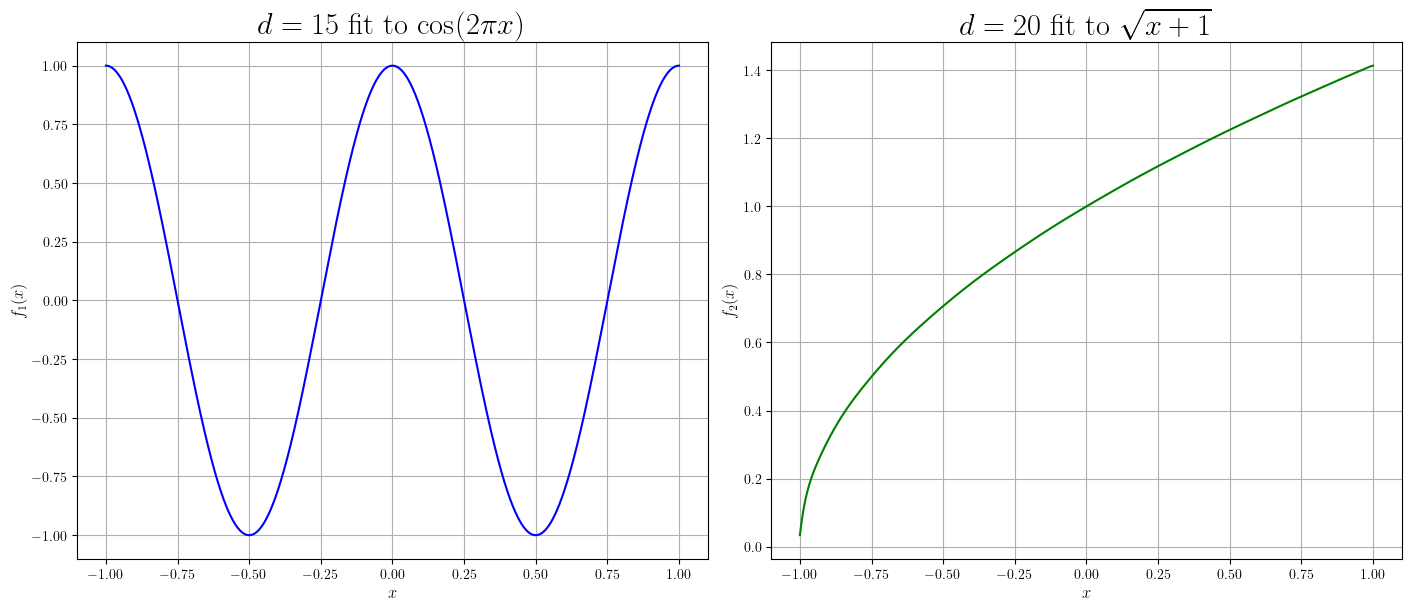

In [364]:
import matplotlib.pyplot as plt
import numpy as np

# Enable LaTeX-style fonts in matplotlib
plt.rcParams.update({
    "text.usetex": True,                  # Use LaTeX for text rendering
    "font.family": "serif",               # Use a serif font
    "font.serif": ["Computer Modern"],     # Specify the serif font
    "axes.labelsize": 12,                 # Font size for axis labels
    "font.size": 12,                      # General font size
    "legend.fontsize": 10,                # Font size for legends
    "xtick.labelsize": 10,                # Font size for x-axis tick labels
    "ytick.labelsize": 10                 # Font size for y-axis tick labels
})

# Create a figure with 2 side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# Plot for f1_vals
axes[0].plot(x_vals, f1_vals, color='blue', label=r'$f_1(x)$')
axes[0].set_xlabel(r'$x$')
axes[0].set_ylabel(r'$f_1(x)$')
axes[0].set_title(r'$d = 15$ fit to $\cos(2\pi x)$')
axes[0].grid(True)

# Plot for f2_vals
axes[1].plot(x_vals, f2_vals, color='green', label=r'$f_2(x)$')
axes[1].set_xlabel(r'$x$')
axes[1].set_ylabel(r'$f_2(x)$')
axes[1].set_title(r'$d = 20$ fit to $\sqrt{x+1}$')
axes[1].grid(True)

plt.savefig(
    r'C:\Users\0josh\OneDrive\Desktop\Re-organised Honours Year\Thesis Documents\QET Plots\other_plots.png',
    dpi=300, bbox_inches='tight', transparent=True
)

# Display the plots
plt.show()
